## Feature Extraction Using P-value

In [6]:
import seaborn as sns
import pandas as pd
import numpy as np

data_x = pd.read_csv('../data/clean/demo_caries_x.csv', index_col=False)
data_y = pd.read_csv('../data/clean/demo_caries_y.csv', index_col=False)
data = pd.concat([data_x, data_y], axis = 1)
df_caries = data.drop(columns="ID")
df_caries.head()

,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMDBORN4,DMDCITZN,DMDEDUC3,DMDEDUC2,...,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR,OUTPUT
0,1.103065,-0.117923,-0.224917,-1.022062,1.255341,0.370975,-0.455735,-0.258301,0.733099,-0.370353,...,-0.270316,-2.660909,-0.095293,-0.101203,-0.962825,-0.703204,-0.272598,-0.252338,-0.258429,1
1,1.817111,-0.117923,-0.224917,0.978139,1.301970,-4.635980,-0.455735,-0.258301,0.710193,0.854105,...,-0.270316,-0.661851,1.368985,1.286272,-0.962825,-0.464729,-0.056912,-0.029714,1.506775,1
2,1.539426,-0.117923,-0.224917,0.978139,-0.275011,0.370975,-0.455735,-0.258301,-0.093382,-1.594812,...,-0.123348,-0.001640,0.355376,0.336546,1.038318,0.250693,-0.560180,-0.549171,-0.633454,0
3,-0.007673,-0.117923,-0.224917,0.978139,-0.220630,0.370975,-0.455735,-0.258301,-0.051323,2.078564,...,0.317557,0.097166,2.779416,2.741962,1.038318,0.489168,0.302565,0.341327,1.823606,0
4,1.975787,-0.117923,-0.224917,-1.022062,1.568519,0.370975,-0.455735,-0.258301,1.055281,2.078564,...,-0.270316,1.337206,0.922431,0.819710,-0.962825,1.204591,0.230670,0.267119,1.823606,1


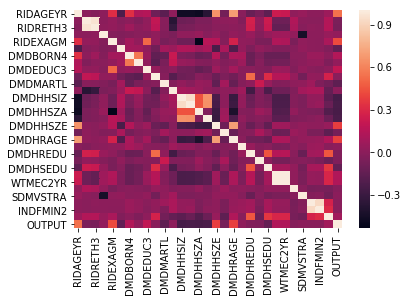

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

# Correlation metrics
data = df_caries
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')
corr = data.corr()
sns.heatmap(corr)


# Next, we compare the correlation between features 
# and remove one of two features that have a correlation higher than 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data = data[selected_columns]

# pvalue feature selection
selected_columns = selected_columns[1:].values

import statsmodels.formula.api as sm

def backward_elimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

SL = 0.05
data_modeled, selected_columns = backward_elimination(data.iloc[:,1:].values, data.iloc[:,0].values, SL, selected_columns)


# Moving the result to a new Dataframe
result = pd.DataFrame()
result['diagnosis'] = data.iloc[:,0]

# Creating a Dataframe with the columns selected using the p-value and correlation
fs_data = pd.DataFrame(data = data_modeled, columns = selected_columns)

In [11]:
print(fs_data.shape)
fs_data.head()

(3552, 14)


,RIDRETH1,RIDEXAGM,DMQMILIZ,DMDBORN4,DMDEDUC3,DMDHHSIZ,DMDHHSZA,DMDHHSZE,DMDHRGND,DMDHRAGE,DMDHREDU,WTINT2YR,INDFMPIR,OUTPUT
0,-0.117923,1.255341,0.370975,-0.455735,0.733099,0.000000,-0.755554,-0.526156,-1.012893,0.599715,-0.393902,-0.095293,-0.258429,1.0
1,-0.117923,1.301970,-4.635980,-0.455735,0.710193,-1.204028,-0.755554,2.400869,-1.012893,1.767546,0.412606,1.368985,1.506775,1.0
2,-0.117923,-0.275011,0.370975,-0.455735,-0.093382,-1.806042,-0.755554,0.937357,-1.012893,1.313390,-1.200410,0.355376,-0.633454,0.0
3,-0.117923,-0.220630,0.370975,-0.455735,-0.051323,-0.602014,-0.755554,-0.526156,0.986993,-1.216911,1.219113,2.779416,1.823606,0.0
4,-0.117923,1.568519,0.370975,-0.455735,1.055281,-1.204028,-0.755554,2.400869,-1.012893,2.027064,1.219113,0.922431,1.823606,1.0


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

KeyboardInterrupt: 

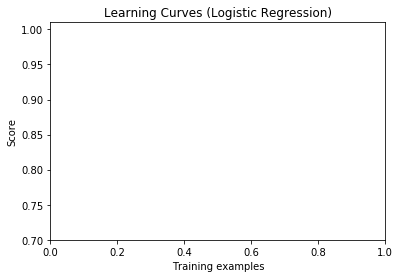

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 30% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                          solver='sgd', verbose=0,  random_state=123,tol=0.000000001)
plot_learning_curve(estimator, title, fs_data.drop(columns=["OUTPUT"]), fs_data['OUTPUT'], ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [24]:
import statsmodels.api as sm

results = sm.OLS(df_caries["OUTPUT"], df_caries.drop(columns=["OUTPUT"])).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 OUTPUT   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     121.2
Date:                Mon, 03 Jun 2019   Prob (F-statistic):               0.00
Time:                        19:09:33   Log-Likelihood:                -336.90
No. Observations:                3552   AIC:                             733.8
Df Residuals:                    3522   BIC:                             919.1
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RIDAGEYR       0.0058      0.000     36.939      0.0